In [1]:
import sys
print(sys.version)

import pandas as pd
import numpy as np
import os
import scanpy as sc
import scvelo as scv
import scirpy as ir
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy.external as sce
import seaborn as sns
import matplotlib.ticker as mtick

plt.rcParams['font.sans-serif']=['Arial']
sc.settings.verbosity = 3  
sc.settings.set_figure_params(dpi=120,fontsize=8, frameon=False, figsize=(3, 3), facecolor='white')
sc.logging.print_versions()

3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
-----
anndata     0.8.0
scanpy      1.9.1
-----
Levenshtein                 5
PIL                         8.2.0
adjustText                  NA
airr                        1.4.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
cffi                        1.14.6
cloudpickle                 1.6.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2021.07.2
dateutil                    2.8.1
decorator                   5.0.9
fsspec                      2021.07.0
google                      NA
h5py                        3.7.0
igraph                      0.9.6
ipykernel                   6.1.0
ipython_genutils            0.2.0
ipywidgets                  7.6.3
jedi                        0.18.0
joblib                      1.0.1
kiwisolver                  1.3.1
leidenalg              

## Pipeline
1. preprocessing for each sample
2. combined all samples
3. normalization
4. batch effect correction
5. clustering
6. canonical markers certification

### Preprocessing & normalization function

In [ ]:
def preprocessing(adata, filter_cells, barc = '-1'):
    sc.pp.filter_genes(adata, min_cells=0.001*len(adata.obs))
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    adata.var['rb'] = adata.var_names.str.contains('^RP[SL]')
    adata.var['hb'] = adata.var_names.str.contains('^HB[APS]')
    adata.var['hsp'] = adata.var_names.str.contains('^HSP')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rb','hb','hsp'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 8000, :]
    adata = adata[adata.obs.n_genes_by_counts > 400, :]
    adata = adata[adata.obs.total_counts > 500, :]
    adata = adata[adata.obs.total_counts < 50000, :]
    adata = adata[adata.obs.pct_counts_mt < 10, :]
    adata = adata[adata.obs.pct_counts_hb < 5, :]
    if len(filter_cells)>0:
        pre_cell = len(adata.obs_names)
        cell_names = adata.obs_names.str.replace('-1',barc)
        adata = adata[~cell_names.isin(filter_cells)]
        after_cell = len(adata.obs_names)
        print("{0} cells filtered by double and mix".format(pre_cell-after_cell) )
    return adata

def normalization(adata, n_top = 5000):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=n_top)
    #adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 
                              'pct_counts_mt', 'pct_counts_hsp'])
    sc.tl.pca(adata, svd_solver='arpack')
    return adata

def getTypeCells(adata, meta, cell_type):
    cells = list(set(meta[meta['leiden_name'].isin(cell_type)].index) & set(adata.obs.index))
    res = adata[adata.obs.index.isin(cells)]
    return res

In [2]:
ALL_CELLS_PATH = 'project_path/SC_data/allCells.h5ad'
T_CELLS_PATH = 'project_path/SC_data/Tcell.h5ad'
B_CELLS_PATH = 'project_path/SC_data/Bcell.h5ad'
MYELOID_CELLS_PATH = 'project_path/SC_data/Myeloids.h5ad'

## All cells

In [ ]:
folder = '/share2/pub/zhangyr/zhangyr/cooperation/SJTU/ESCC/cellranger_v6/'

In [ ]:
A_pre_ori = sc.read_10x_mtx(os.path.join(folder,'A_1_0/outs/filtered_feature_bc_matrix/'),cache=True)
A_post_ori = sc.read_10x_mtx(os.path.join(folder,'A_1_1/outs/filtered_feature_bc_matrix'),cache=True)
B_pre_ori = sc.read_10x_mtx(os.path.join(folder,'B_1_0/outs/filtered_feature_bc_matrix'),cache=True)
B_post_ori = sc.read_10x_mtx(os.path.join(folder,'B_1_1/outs/filtered_feature_bc_matrix'),cache=True)
C_pre_ori = sc.read_10x_mtx(os.path.join(folder,'C_1_0/outs/filtered_feature_bc_matrix'),cache=True)
C_post_ori = sc.read_10x_mtx(os.path.join(folder,'C_1_1/outs/filtered_feature_bc_matrix'),cache=True)
D_pre_ori = sc.read_10x_mtx(os.path.join(folder,'D_1_0/outs/filtered_feature_bc_matrix'),cache=True)
D_post_ori = sc.read_10x_mtx(os.path.join(folder,'D_1_1/outs/filtered_feature_bc_matrix'),cache=True)
I_pre_ori = sc.read_10x_mtx(os.path.join(folder,'I_1_0/outs/filtered_feature_bc_matrix'),cache=True)
I_post_ori = sc.read_10x_mtx(os.path.join(folder,'I_1_1/outs/filtered_feature_bc_matrix'),cache=True)
R_pre_ori = sc.read_10x_mtx(os.path.join(folder,'R_1_0/outs/filtered_feature_bc_matrix'),cache=True)
R_post_ori = sc.read_10x_mtx(os.path.join(folder,'R_1_1/outs/filtered_feature_bc_matrix'),cache=True)
N_pre_ori = sc.read_10x_mtx(os.path.join(folder,'N_1_0/outs/filtered_feature_bc_matrix'),cache=True)
N_post_ori = sc.read_10x_mtx(os.path.join(folder,'N_1_1/outs/filtered_feature_bc_matrix'),cache=True)

In [ ]:
A_pre = preprocessing(A_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-1')
A_post = preprocessing(A_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-2')
B_pre = preprocessing(B_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-3')
B_post = preprocessing(B_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-4')
C_pre = preprocessing(C_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-5')
C_post = preprocessing(C_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-6')
D_pre = preprocessing(D_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-7')
D_post = preprocessing(D_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-8')
I_pre = preprocessing(I_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-9')
I_post = preprocessing(I_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-10')
R_pre = preprocessing(R_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-11')
R_post = preprocessing(R_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-12')
N_pre = preprocessing(N_pre_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-13')
N_post = preprocessing(N_post_ori,list(doublet.iloc[:,0])+list(mix['Barcode']), '-14')

In [ ]:
A_con = A_pre.concatenate(A_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
B_con = B_pre.concatenate(B_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
C_con = C_pre.concatenate(C_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
D_con = D_pre.concatenate(D_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
I_con = I_pre.concatenate(I_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
R_con = R_pre.concatenate(R_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
N_con = N_pre.concatenate(N_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')

In [ ]:
adata_con = A_con.concatenate([B_con,C_con, D_con, I_con, R_con, N_con], 
                              batch_categories=['A', 'B','C','D','I','R','N'],
                              batch_key = 'patient')
adata_con.obs['treat_patient'] = adata_con.obs['treat'].str.cat(adata_con.obs['patient'],sep='_')

In [ ]:
adata_con = normalization(adata_con,5000)
sc.external.pp.bbknn(adata_con, batch_key='treat_patient',neighbors_within_batch=3)
sc.tl.umap(adata_con)
sc.tl.leiden(adata_con,resolution=0.3)
sc.pl.umap(adata_con, color=['patient', 'treat', 'leiden'])

In [3]:
adata_con = sc.read_h5ad(ALL_CELLS_PATH)

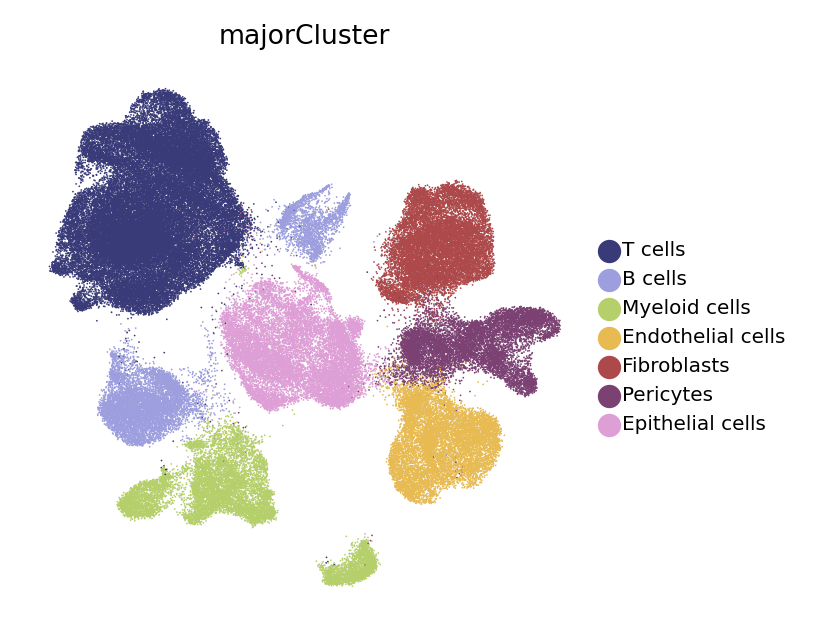

In [4]:
sc.pl.umap(adata_con, color=['majorCluster'], legend_fontsize=6)

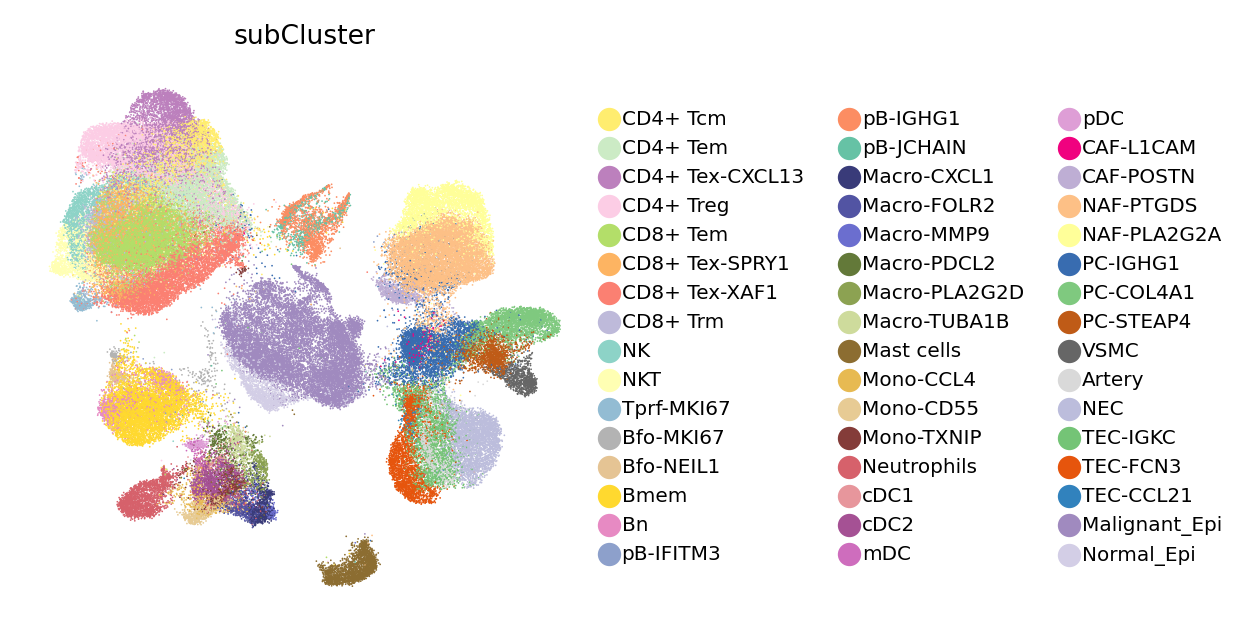

In [5]:
sc.pl.umap(adata_con, color=['subCluster'], legend_fontsize=6)

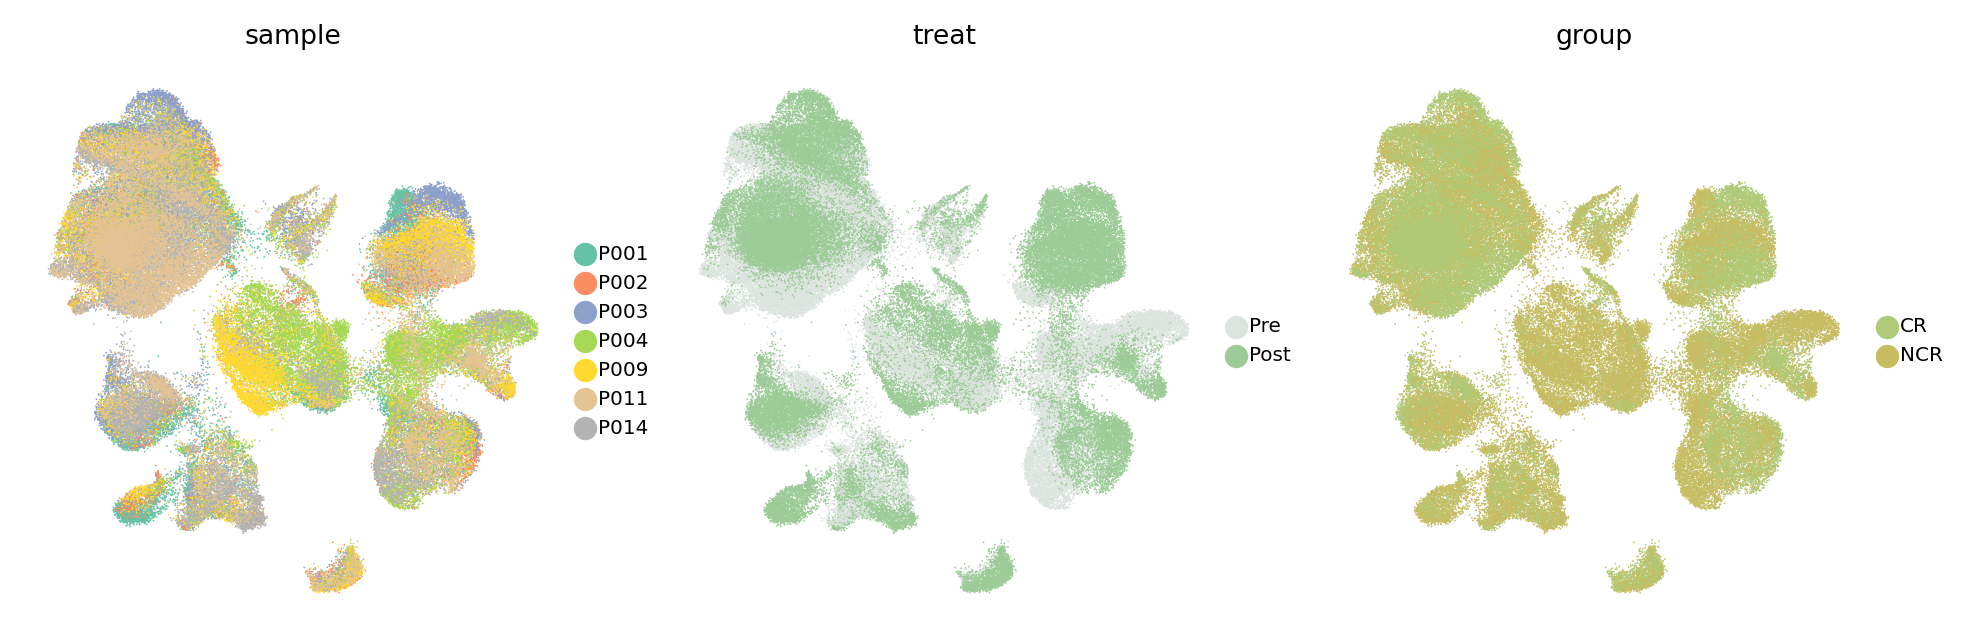

In [6]:
sc.pl.umap(adata_con, color=['sample','treat','group'], legend_fontsize=6,wspace=0.1)

In [7]:
immu_markers = ["CD3D","CD2","CD3E","CD3G",   ## T cell
                "CD79A",'MS4A1',"CD79B","JCHAIN",  ## B cell
                "DCN","COL1A1","COL1A2","FN1",  ## fibroblast
                "CCL14","VWF","PECAM1","ENG",    ## endothelial cell
                "RGS5","MCAM","ACTA2","MYH11",    ## pericyte
                "LYZ","CD14","GCA","HPGDS",  ## myeloid cell
                'KRT5','SFN','KRT14','EPCAM'  ## epithelial cell
               ]  
#sc.pl.umap(adata_con, color=immu_markers)

## T cells

In [ ]:
celltype = ['T cells']
A_pre_ori = getTypeCells(A_pre_ori, meta_data, celltype)
A_post_ori = getTypeCells(A_post_ori, meta_data, celltype)
B_pre_ori = getTypeCells(B_pre_ori, meta_data, celltype)
B_post_ori = getTypeCells(B_post_ori, meta_data, celltype)
C_pre_ori = getTypeCells(C_pre_ori, meta_data, celltype)
C_post_ori = getTypeCells(C_post_ori, meta_data, celltype)
D_pre_ori = getTypeCells(D_pre_ori, meta_data, celltype)
D_post_ori = getTypeCells(D_post_ori, meta_data, celltype)
I_pre_ori = getTypeCells(I_pre_ori, meta_data, celltype)
I_post_ori = getTypeCells(I_post_ori, meta_data, celltype)
R_pre_ori = getTypeCells(R_pre_ori, meta_data, celltype)
R_post_ori = getTypeCells(R_post_ori, meta_data, celltype)
N_pre_ori = getTypeCells(N_pre_ori, meta_data, celltype)
N_post_ori = getTypeCells(N_post_ori, meta_data, celltype)

In [ ]:
A_pre = preprocessing(A_pre_ori,[])
A_post = preprocessing(A_post_ori,[])
B_pre = preprocessing(B_pre_ori,[])
B_post = preprocessing(B_post_ori,[])
C_pre = preprocessing(C_pre_ori,[])
C_post = preprocessing(C_post_ori,[])
D_pre = preprocessing(D_pre_ori,[])
D_post = preprocessing(D_post_ori,[])
I_pre = preprocessing(I_pre_ori,[])
I_post = preprocessing(I_post_ori,[])
R_pre = preprocessing(R_pre_ori,[])
R_post = preprocessing(R_post_ori,[])
N_pre = preprocessing(N_pre_ori,[])
N_post = preprocessing(N_post_ori,[])

In [ ]:
A_con = A_pre.concatenate(A_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
B_con = B_pre.concatenate(B_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
C_con = C_pre.concatenate(C_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
D_con = D_pre.concatenate(D_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
I_con = I_pre.concatenate(I_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
R_con = R_pre.concatenate(R_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
N_con = N_pre.concatenate(N_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')

tcell = A_con.concatenate([B_con,C_con, D_con, I_con, R_con, N_con], 
                              batch_categories=['A', 'B','C','D','I','R','N'],
                              batch_key = 'sample')
tcell.obs['treat_sample'] = tcell.obs['treat'].str.cat(tcell.obs['sample'],sep='_')

In [ ]:
tcell = normalization(tcell, n_top = 5000)
sc.external.pp.bbknn(tcell, batch_key='treat_sample',neighbors_within_batch=6)
sc.tl.umap(tcell)
sc.tl.leiden(tcell,resolution=0.9)
sc.pl.umap(tcell, color=['sample','treat','leiden'])

In [8]:
tcell = sc.read_h5ad(T_CELLS_PATH)

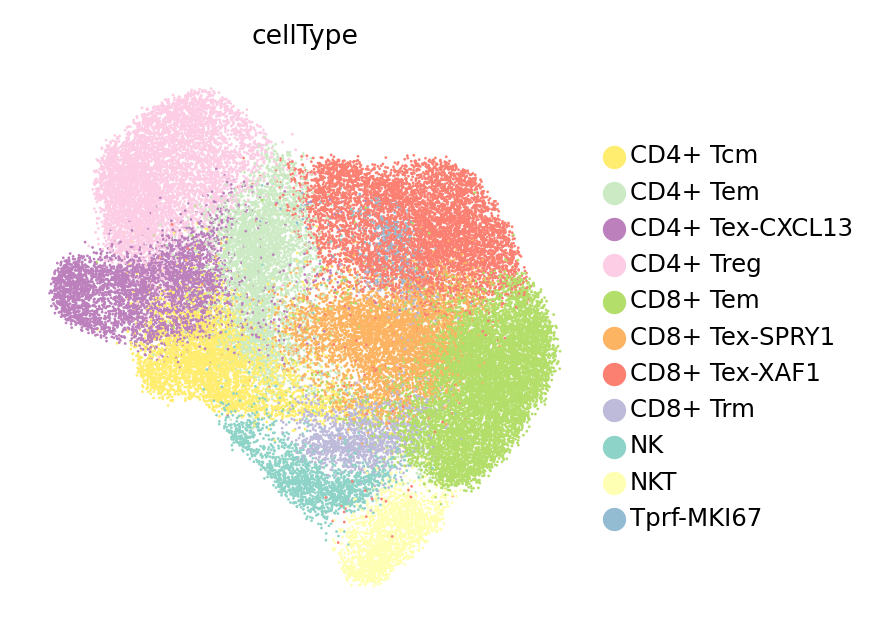

In [9]:
sc.pl.umap(tcell, color=['cellType'])

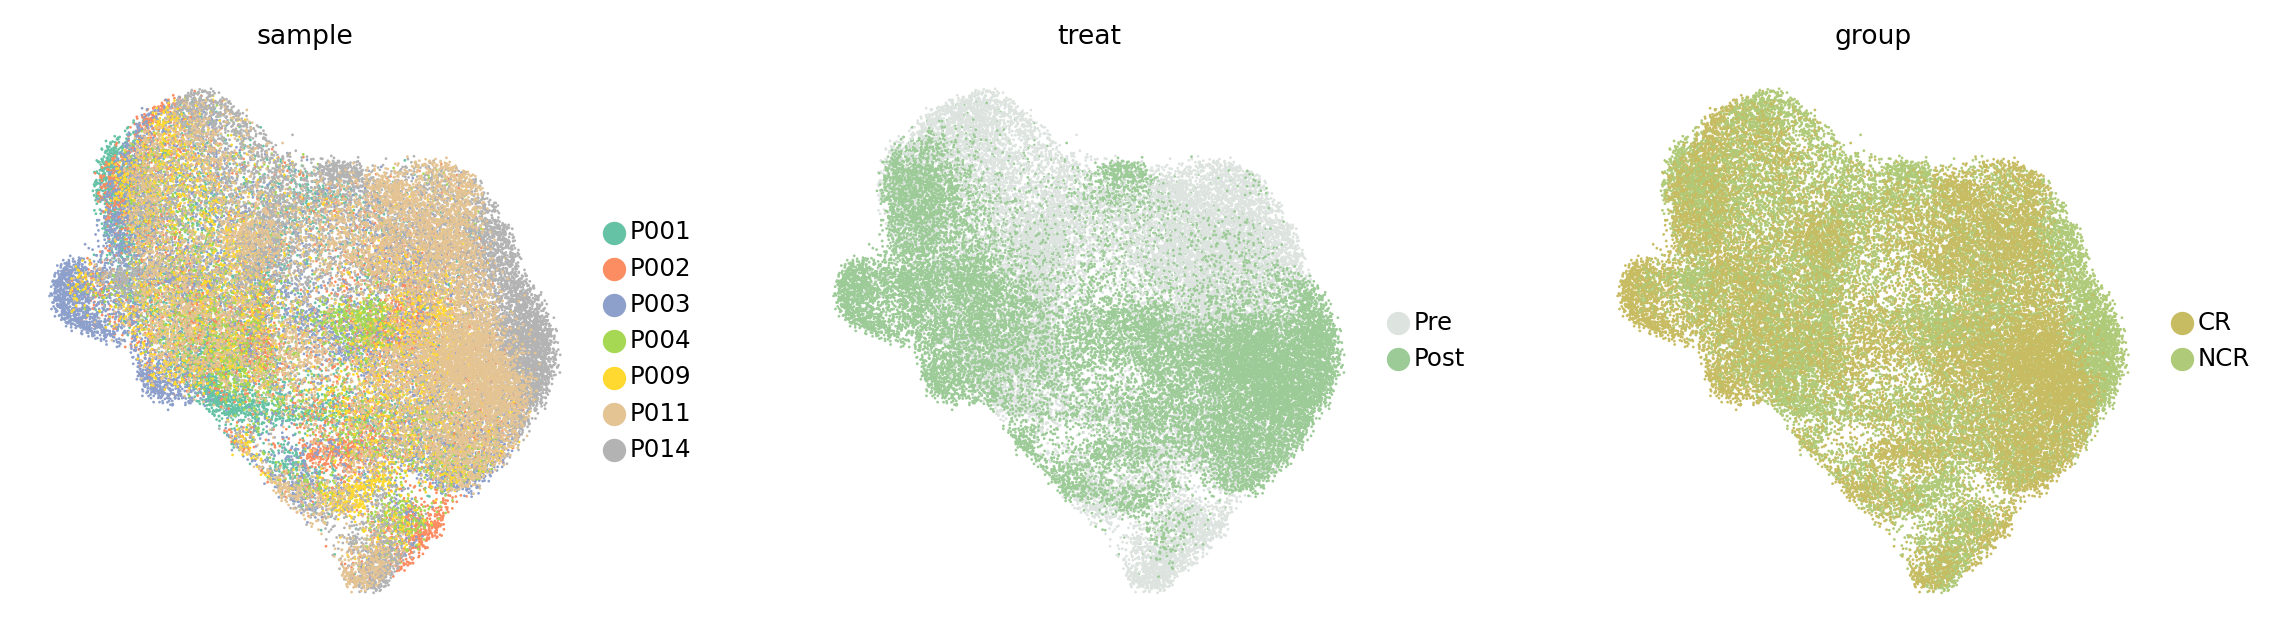

In [10]:
sc.pl.umap(tcell, color=['sample','treat','group'])

In [11]:
t_marker = ['CD8A','CD4','MKI67','NKG7',
            'CCL4L2','GZMK', 'FGFBP2','GNLY',
            'PDCD1','CXCL13','CXCL9','HAVCR2','CD69',
            'TCF7','SLAMF6','ID3','ID2','IL7R','CCR5','CXCR5']
#sc.pl.umap(tcell, color=t_marker)

## B cells

In [ ]:
celltype = ['B cells']
A_pre_ori = getTypeCells(A_pre_ori, meta_data, celltype)
A_post_ori = getTypeCells(A_post_ori, meta_data, celltype)
B_pre_ori = getTypeCells(B_pre_ori, meta_data, celltype)
B_post_ori = getTypeCells(B_post_ori, meta_data, celltype)
C_pre_ori = getTypeCells(C_pre_ori, meta_data, celltype)
C_post_ori = getTypeCells(C_post_ori, meta_data, celltype)
D_pre_ori = getTypeCells(D_pre_ori, meta_data, celltype)
D_post_ori = getTypeCells(D_post_ori, meta_data, celltype)
I_pre_ori = getTypeCells(I_pre_ori, meta_data, celltype)
I_post_ori = getTypeCells(I_post_ori, meta_data, celltype)
R_pre_ori = getTypeCells(R_pre_ori, meta_data, celltype)
R_post_ori = getTypeCells(R_post_ori, meta_data, celltype)
N_pre_ori = getTypeCells(N_pre_ori, meta_data, celltype)
N_post_ori = getTypeCells(N_post_ori, meta_data, celltype)

In [ ]:
A_pre = preprocessing(A_pre_ori,[])
A_post = preprocessing(A_post_ori,[])
B_pre = preprocessing(B_pre_ori,[])
B_post = preprocessing(B_post_ori,[])
C_pre = preprocessing(C_pre_ori,[])
C_post = preprocessing(C_post_ori,[])
D_pre = preprocessing(D_pre_ori,[])
D_post = preprocessing(D_post_ori,[])
I_pre = preprocessing(I_pre_ori,[])
I_post = preprocessing(I_post_ori,[])
R_pre = preprocessing(R_pre_ori,[])
R_post = preprocessing(R_post_ori,[])
N_pre = preprocessing(N_pre_ori,[])
N_post = preprocessing(N_post_ori,[])

In [ ]:
A_con = A_pre.concatenate(A_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
B_con = B_pre.concatenate(B_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
C_con = C_pre.concatenate(C_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
D_con = D_pre.concatenate(D_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
I_con = I_pre.concatenate(I_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
R_con = R_pre.concatenate(R_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
N_con = N_pre.concatenate(N_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')

adata_con = A_con.concatenate([B_con,C_con, D_con, I_con, R_con, N_con], 
                              batch_categories=['A', 'B','C','D','I','R','N'],
                              batch_key = 'sample')
adata_con.obs['treat_sample'] = adata_con.obs['treat'].str.cat(adata_con.obs['sample'],sep='_')

In [ ]:
adata_con = normalization(adata_con, n_top = 3000)
sc.external.pp.bbknn(adata_con, batch_key='treat_sample')
sc.tl.umap(adata_con)
sc.tl.leiden(adata_con,resolution=0.5)
sc.pl.umap(adata_con, color=['sample', 'treat', 'leiden'])

In [12]:
Bcell = sc.read_h5ad(B_CELLS_PATH)

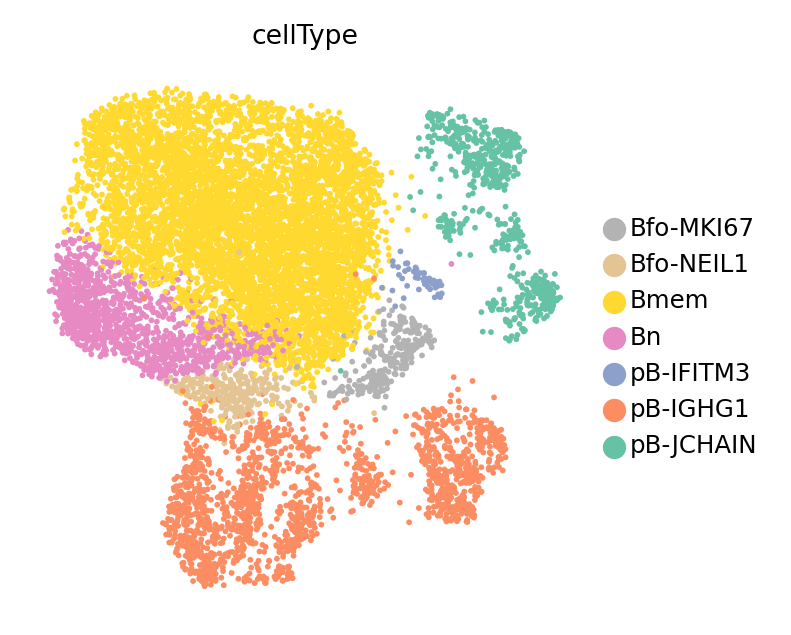

In [13]:
sc.pl.umap(Bcell, color=['cellType'])

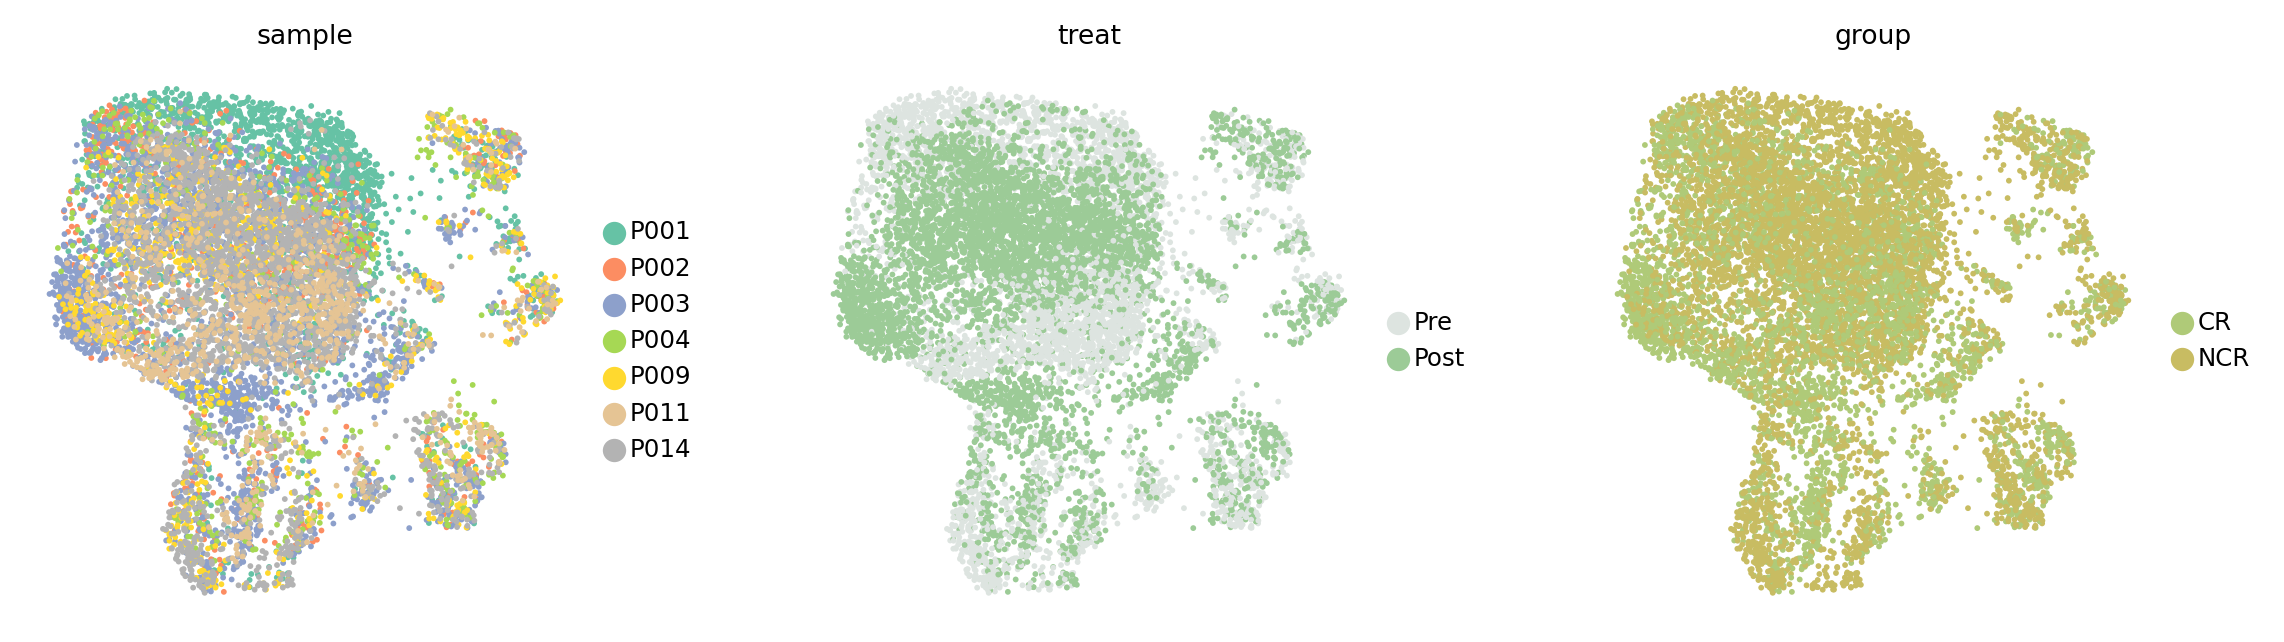

In [14]:
sc.pl.umap(Bcell, color=['sample','treat','group'])

In [15]:
b_markers = ['CD19','IGHG1','MZB1','XBP1','CXCR5',
           'BACH2','IL4R','FCER2','TCL1A','IGHD',
           'IGHM','IGHA1','TNFRSF13B','CCR7',
           'RGS13','NEIL1','MEF2B','BCL6','MKI67','JCHAIN']
#sc.pl.umap(Bcell, color=b_markers)

## Myeloid cells

In [ ]:
celltype = ['Myeloid cells']
A_pre_ori = getTypeCells(A_pre_ori, meta_data, celltype)
A_post_ori = getTypeCells(A_post_ori, meta_data, celltype)
B_pre_ori = getTypeCells(B_pre_ori, meta_data, celltype)
B_post_ori = getTypeCells(B_post_ori, meta_data, celltype)
C_pre_ori = getTypeCells(C_pre_ori, meta_data, celltype)
C_post_ori = getTypeCells(C_post_ori, meta_data, celltype)
D_pre_ori = getTypeCells(D_pre_ori, meta_data, celltype)
D_post_ori = getTypeCells(D_post_ori, meta_data, celltype)
I_pre_ori = getTypeCells(I_pre_ori, meta_data, celltype)
I_post_ori = getTypeCells(I_post_ori, meta_data, celltype)
R_pre_ori = getTypeCells(R_pre_ori, meta_data, celltype)
R_post_ori = getTypeCells(R_post_ori, meta_data, celltype)
N_pre_ori = getTypeCells(N_pre_ori, meta_data, celltype)
N_post_ori = getTypeCells(N_post_ori, meta_data, celltype)

In [ ]:
A_pre = preprocessing(A_pre_ori,[])
A_post = preprocessing(A_post_ori,[])
B_pre = preprocessing(B_pre_ori,[])
B_post = preprocessing(B_post_ori,[])
C_pre = preprocessing(C_pre_ori,[])
C_post = preprocessing(C_post_ori,[])
D_pre = preprocessing(D_pre_ori,[])
D_post = preprocessing(D_post_ori,[])
I_pre = preprocessing(I_pre_ori,[])
I_post = preprocessing(I_post_ori,[])
R_pre = preprocessing(R_pre_ori,[])
R_post = preprocessing(R_post_ori,[])
N_pre = preprocessing(N_pre_ori,[])
N_post = preprocessing(N_post_ori,[])

In [ ]:
A_con = A_pre.concatenate(A_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
B_con = B_pre.concatenate(B_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
C_con = C_pre.concatenate(C_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
D_con = D_pre.concatenate(D_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
I_con = I_pre.concatenate(I_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
R_con = R_pre.concatenate(R_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')
N_con = N_pre.concatenate(N_post, batch_categories=['Pre', 'Post'],batch_key = 'treat')

adata_con = A_con.concatenate([B_con,C_con, D_con, I_con, R_con, N_con], 
                              batch_categories=['A', 'B','C','D','I','R','N'],
                              batch_key = 'sample')
adata_con.obs['treat_sample'] = adata_con.obs['treat'].str.cat(adata_con.obs['sample'],sep='_')

In [ ]:
adata_con = normalization(adata_con,min_cells=3, n_top = 3000)
sc.external.pp.bbknn(adata_con, batch_key='treat_sample')
sc.tl.umap(adata_con)
sc.tl.leiden(adata_con,resolution=0.5)
sc.pl.umap(adata_con, color=['sample', 'treat', 'leiden'])

In [16]:
mye = sc.read_h5ad(MYELOID_CELLS_PATH)

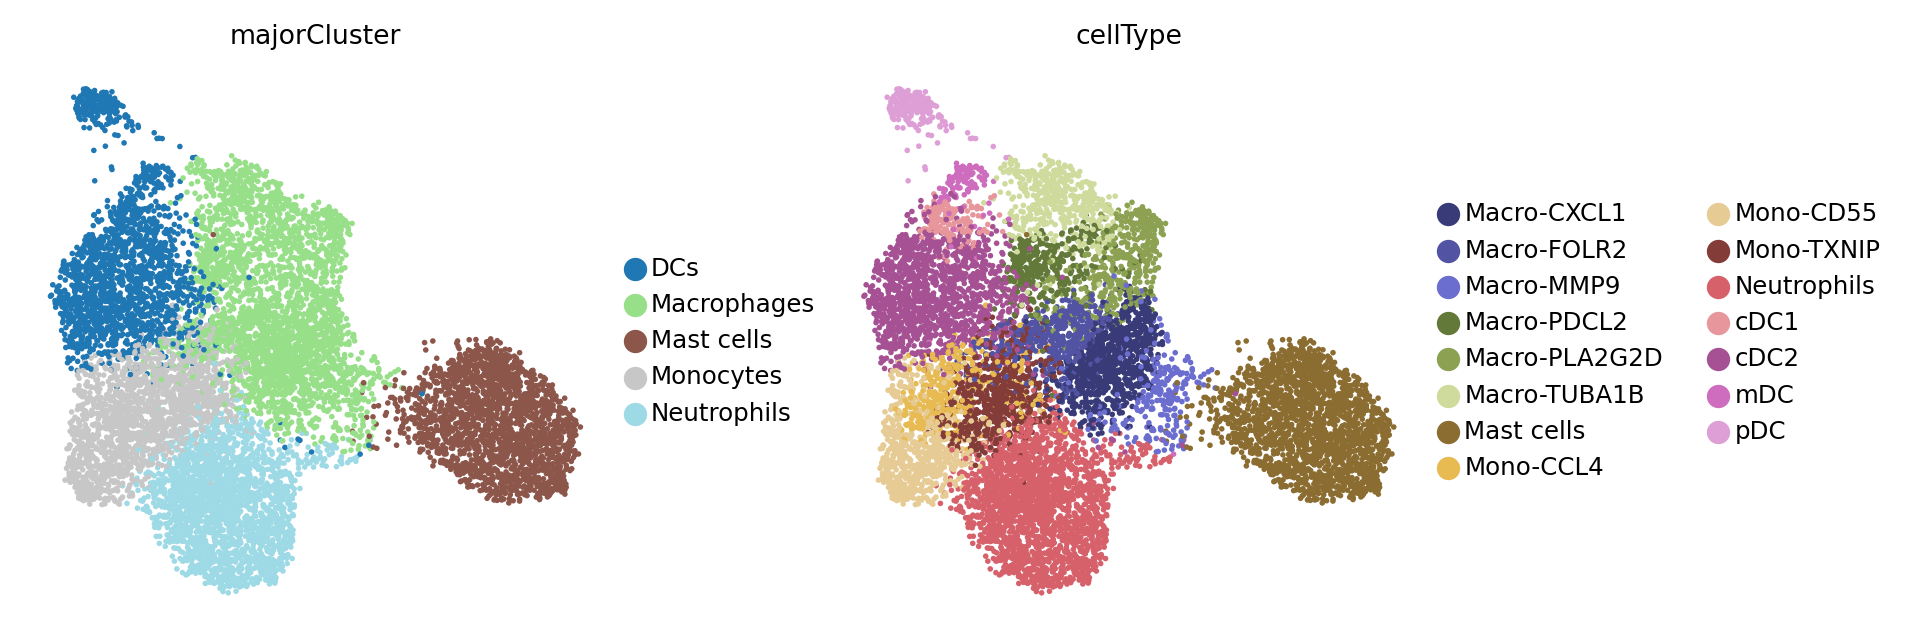

In [17]:
sc.pl.umap(mye, color=['majorCluster','cellType'])

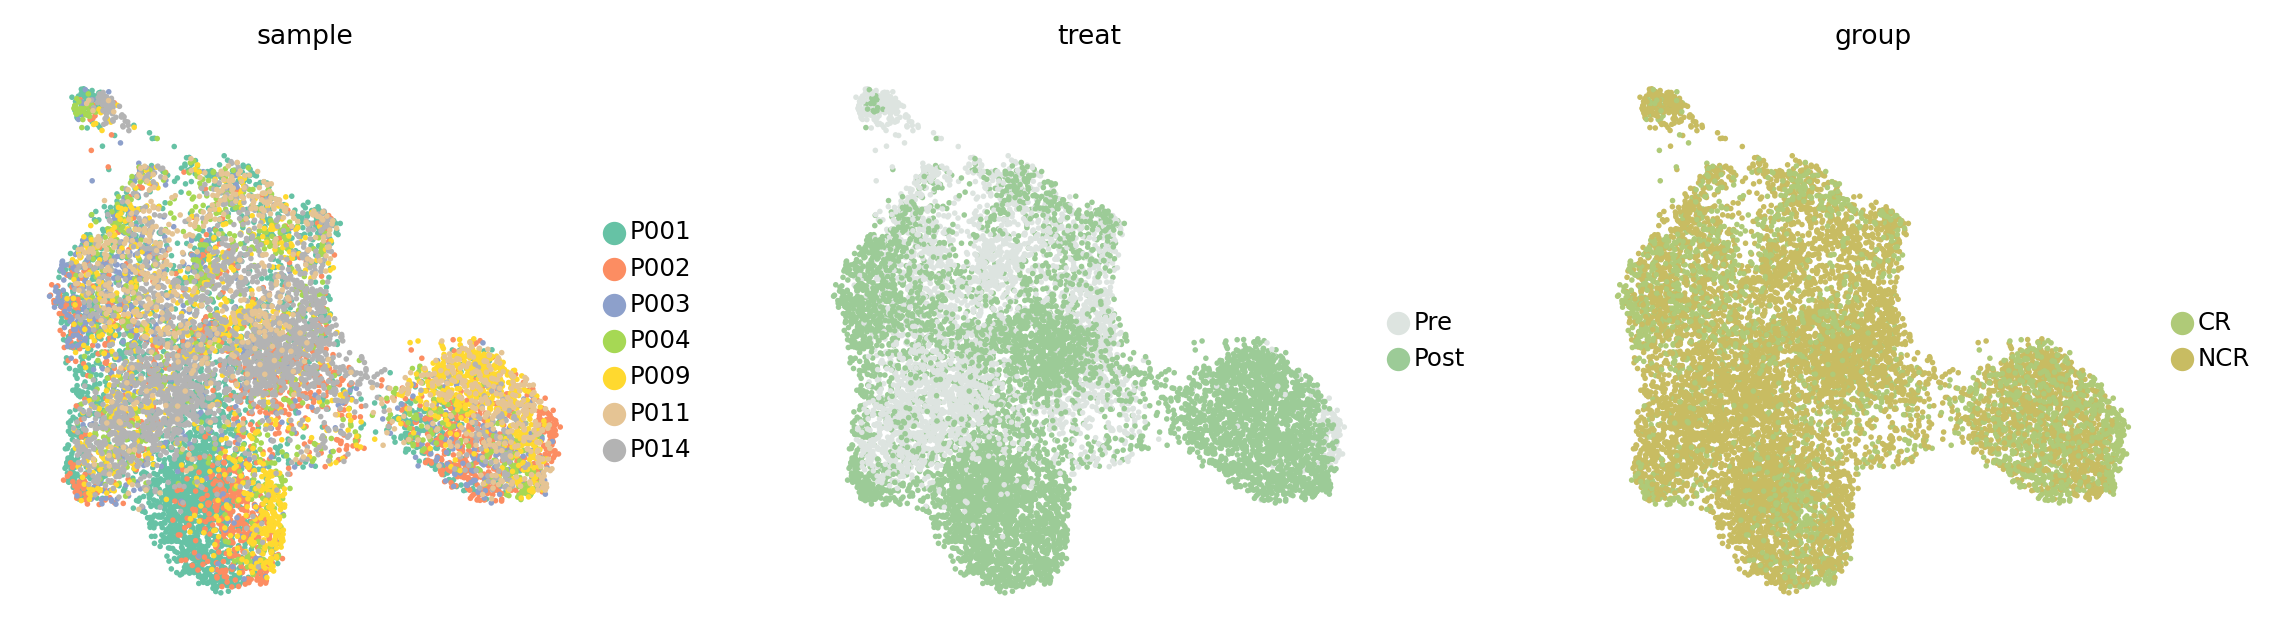

In [18]:
sc.pl.umap(mye, color=['sample','treat','group'])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_majorCluster']`


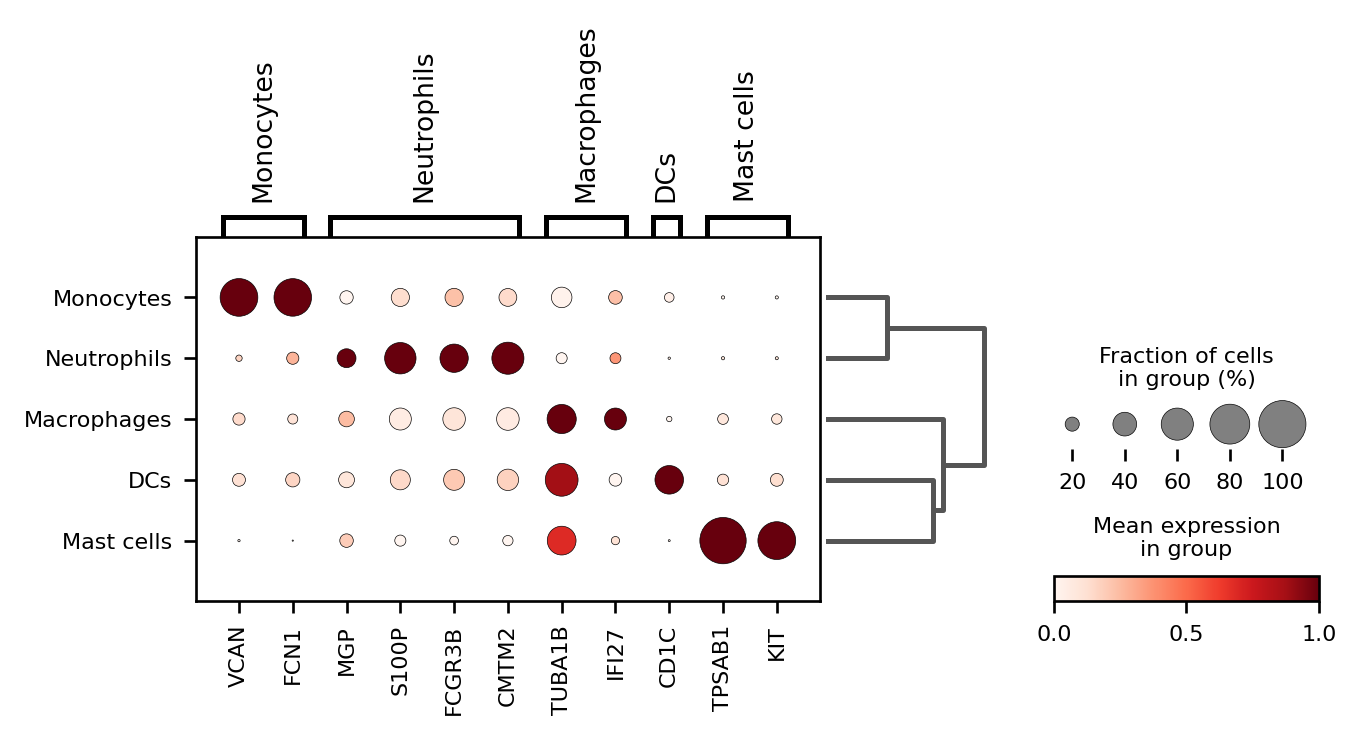

In [19]:
markers = {
    'Neutrophils':['MGP','S100P','FCGR3B','CMTM2'],
    'Monocytes':['VCAN','FCN1'],
    'Macrophages':['TUBA1B','IFI27'],
    'Mast cells':['TPSAB1','KIT'],
    'DCs':['CD1C']
}
sc.pl.dotplot(mye, markers, 'majorCluster',var_group_labels =None,
              standard_scale ='var', 
              cmap='Reds',figsize=(6,2),
              dendrogram=True)